### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

**<span style='color:#1a2f40'>Author:**</span> Cristina Varas Menadas</br>
**<span style='color:#1a2f40'>Title:**</span> EMEA Data Science, Vector & ML</br>
**<span style='color:#1a2f40'>Company:**</span> Oracle
</br></br>

**<span style='color:#1a2f40'>Description:**</span> In this notebook we will explore how we can take a catalog of images and embed them using an open-source model `RestNet50` in order to store them within Oracle Database 23ai in order to perform similarity search across our image catalog. We will be using the `oracledb` python SDK to interact with Oracle Database 23ai with AI Vector Search Capabilities.

## 1. Imports

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

In [ ]:
!pip install transformers

In [1]:
import os
import math
import array
import numpy as np
import pandas as pd
import base64
import oracledb
import gradio as gr
from tqdm import tqdm
from io import BytesIO
from PIL import Image
from dotenv import load_dotenv
from io import BytesIO

from transformers import AutoImageProcessor, ResNetForImageClassification

## 2. Load Images
- **Pick the source folder**: `image_dir` points to the dataset’s `images` directory.
- **Collect filenames**: builds a list of up to 1,000 `.jpg` files and shows a quick preview (`filenames[0:5]`).
- **Build a tracking table** (`image_df`):
  - `FILENAME`: the image file name.
  - `FILEPATH`: full path via `os.path.join(image_dir, FILENAME)`.
  - `TYPE`: a simple constant label (“Clothes”) for all rows.
  - `IMAGE_ID`: a numeric ID created by resetting the DataFrame index.
- **Load images into memory**: uses PIL to open each `FILEPATH`, creating a `images` list you’ll feed into preprocessing/embedding later.
- **Sanity checks**: prints a small preview of the DataFrame and the total counts to confirm everything loaded as expected.

In [2]:
# Define Image Directory
image_dir = '/home/datascience/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-dataset/versions/1/fashion-dataset/images'
#image_dir = './data/data/'
# Load up to 1000 image filenames
filenames = [file for file in os.listdir(image_dir) if file.endswith('.jpg')][:1000]
#filenames = [file for file in os.listdir(image_dir) if file.endswith('.jpg')]

# Preview the first few files
filenames[0:5]


['40997.jpg', '10673.jpg', '30576.jpg', '6512.jpg', '42093.jpg']

In [3]:
# Create a Pandas DF to Store Images
image_df = pd.DataFrame(filenames, columns=['FILENAME'])

# Create a new column that has filepath
image_df['FILEPATH'] = image_df['FILENAME'].map(lambda x: os.path.join(image_dir, x))

# Create a new column that catagorises the files
image_df['TYPE'] = 'Clothes'

# Reset Index and save as ID
image_df = image_df.reset_index()
image_df = image_df.rename(columns={'index':'IMAGE_ID'})

# Preview Data
image_df.head(10)
print(len(image_df))


1000


In [46]:
# Open up images using PIL - store in list
images = list(map(lambda x: Image.open(x), image_df['FILEPATH']))

# Preview First Image
images[0]
print(len(images))

1000


## 3. Prepare images
- **Utility functions**
  - `resize_image(image_path, target_width, target_height)`: loads a file with PIL and resizes it **preserving aspect ratio** (height is derived from the original ratio); returns a resized `PIL.Image`.
  - `convert_image_base64(pil_image)`: encodes a `PIL.Image` to **base64 JPEG** (no data-URL prefix), ready to store in DB or send to APIs.
  - `process_and_save_images(image_df, resized_folder, base64_folder, target_width, target_height, limit)`: loops rows in `image_df` (expects `FILEPATH`),  
    - resizes each image and writes `<name>_resized.jpg` to `resized_folder`,  
    - writes its base64 to `<name>.b64` in `base64_folder`,  
    - returns the list of resized `PIL.Image` objects (same order as the DF slice).

- **Configuration**
  - `base_path`, `image_folder`, `resized_folder`, `base64_folder`: define I/O directories.
  - `target_width/target_height`: target size; width is the driver for aspect-preserving resize.
  - `limit`: optional cap on how many images to process (useful for quick runs).

- **Pipeline steps**
  1. Ensure output folders exist (`os.makedirs(..., exist_ok=True)`).
  2. (Optional) Build a DataFrame from `image_folder` if you haven’t already.
  3. Limit to the first `N` images for this run: `image_df = image_df.head(limit)`.
  4. Call `process_and_save_images(...)` to generate:
     - **Resized JPEGs** on disk.
     - **Base64 files** on disk (`.b64`).
  5. Convert the in-memory resized images to base64 again (quick, no disk I/O) and attach as a new `BASE64` column:
     `image_df['BASE64'] = [convert_image_base64(img) for img in resized_images]`.

- **Why both disk and in-memory?**
  - Disk outputs give you an audit trail and artifacts to reuse.
  - In-memory base64 lets you attach strings directly to `image_df` for **single-pass DB insert** and for **vision API calls** without re-reading files.

In [5]:
def resize_image(image_path, target_width, target_height):
    """
    Resize an image while preserving aspect ratio.

    The image is loaded from `image_path` and scaled so the width equals
    `target_width`; the height is computed from the original aspect ratio.
    Returns a new PIL Image.

    Args:
        image_path (str): Path to the source image.
        target_width (int): Desired output width (pixels).
        target_height (int): Unused in this calculation.

    Returns:
        PIL.Image.Image: The resized image.
    """
    pil_image = Image.open(image_path)
    # Open Image
    image_aspect_ratio = pil_image.width / pil_image.height
    # Get aspect ratio
    new_height = math.floor(target_height / image_aspect_ratio)
    # Resize Image
    resized_pil_image = pil_image.resize((target_width, new_height))
    return resized_pil_image


In [6]:
# Function to convert image to base 64 which we will store in DB
def convert_image_base64(pil_image):
    """
    Encode a PIL Image as a base64 JPEG string (no data-URL prefix).

    Args:
        pil_image (PIL.Image.Image): Image to encode.

    Returns:
        str: Base64-encoded JPEG bytes.

    Notes:
        - Always saves as JPEG. For images with alpha, use .convert("RGB") first.
        - Add prefix yourself if a data URL is required: "data:image/jpeg;base64,".
    """
    
    # Instantiate Byte Stream
    image_data = BytesIO()
    
    # Save image in bytes stream
    pil_image.save(image_data, format='JPEG')
    
    # Encode Image
    base64_string = base64.b64encode(image_data.getvalue()).decode('utf-8')
    
    return base64_string

In [7]:
def process_and_save_images(image_df, resized_folder, base64_folder, target_width, target_height, limit=None):
    """
    Resize images listed in `image_df`, save resized JPEGs and their base64 dumps.

    For each row (expects columns: FILEPATH), the image is resized using
    `resize_image(...)`, written to `resized_folder` as "<name>_resized.jpg",
    and its base64 (from `convert_image_base64`) is written to `base64_folder`
    as "<name>.b64". Returns a list of PIL Images (resized).

    Args:
        image_df (pd.DataFrame): DataFrame with a 'FILEPATH' column.
        resized_folder (str): Output directory for resized JPEGs.
        base64_folder (str): Output directory for .b64 text files.
        target_width (int): Target width in pixels (aspect ratio preserved).
        target_height (int): Target height hint (not used if preserving ratio by width).
        limit (int, optional): Max number of images to process.

    Returns:
        list[PIL.Image.Image]: Resized PIL images in processing order.

    Notes:
        - Filenames are derived from the original basename without extension.
        - Ensure `resized_folder` and `base64_folder` exist (use os.makedirs(..., exist_ok=True)).
        - Consider converting images to RGB before JPEG if they have alpha.
    """
    resized_images = []

    for index, row in image_df.iterrows():
        if limit and index >= limit:
            break

        original_path = row['FILEPATH']
        filename = os.path.splitext(os.path.basename(original_path))[0]

        # Resize and save
        resized_img = resize_image(original_path, target_width, target_height)
        resized_path = os.path.join(resized_folder, f"{filename}_resized.jpg")
        resized_img.save(resized_path)
        resized_images.append(resized_img)

        # Save base64 to file
        base64_str = convert_image_base64(resized_img)
        base64_path = os.path.join(base64_folder, f"{filename}.b64")
        with open(base64_path, 'w') as b64_file:
            b64_file.write(base64_str)

    return resized_images


In [8]:
# Base paths
#base_path = '/home/datascience/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-dataset/versions/1/fashion-dataset'
base_path = '/home/datascience/2-Internal Projects/Developer Coach - 04.09.2025/Images Vector Search/data/data'
image_folder = os.path.join(base_path, 'images')
resized_folder = os.path.join(base_path, 'resized_images')
base64_folder = os.path.join(base_path, 'base64_images')

# Target size
target_width = 256
target_height = 256

# Number of images to process
limit = 10000  # <- Change this number as needed

# Create folders if they don't exist
os.makedirs(resized_folder, exist_ok=True)
os.makedirs(base64_folder, exist_ok=True)

"""
# Load file paths into DataFrame
image_df = pd.DataFrame({
    'FILEPATH': [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')]
})
"""

# Limit to first N images
image_df = image_df.head(limit)

# Process and save images (resized + base64 files)
resized_images = process_and_save_images(
    image_df=image_df,
    resized_folder=resized_folder,
    base64_folder=base64_folder,
    target_width=target_width,
    target_height=target_height,
    limit=limit
)

# Convert to base64 (in-memory) and store in DF
base64_strings = list(map(lambda x: convert_image_base64(x), resized_images))
image_df['BASE64'] = base64_strings

# Preview
image_df.head(10)




,IMAGE_ID,FILENAME,FILEPATH,TYPE,BASE64
0,0,40997.jpg,/home/datascience/.cache/kagglehub/datasets/pa...,Clothes,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,1,10673.jpg,/home/datascience/.cache/kagglehub/datasets/pa...,Clothes,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2,2,30576.jpg,/home/datascience/.cache/kagglehub/datasets/pa...,Clothes,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3,3,6512.jpg,/home/datascience/.cache/kagglehub/datasets/pa...,Clothes,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
4,4,42093.jpg,/home/datascience/.cache/kagglehub/datasets/pa...,Clothes,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
5,5,22625.jpg,/home/datascience/.cache/kagglehub/datasets/pa...,Clothes,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
6,6,46312.jpg,/home/datascience/.cache/kagglehub/datasets/pa...,Clothes,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
7,7,47174.jpg,/home/datascience/.cache/kagglehub/datasets/pa...,Clothes,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
8,8,15821.jpg,/home/datascience/.cache/kagglehub/datasets/pa...,Clothes,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
9,9,57506.jpg,/home/datascience/.cache/kagglehub/datasets/pa...,Clothes,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [9]:
len(image_df)

1000

### 3.1. Generating Image Embeddings with ResNet-50 (Hugging Face + PyTorch)
**What this does:**  
Converts each image into a fixed-length numeric vector (an *embedding*) using a pretrained ResNet-50. You can use these vectors later for similarity search (e.g., in Oracle’s `VECTOR` column).

**Key components:**
- `AutoImageProcessor.from_pretrained('microsoft/resnet-50')` — handles resize, normalization, and tensor conversion.
- `ResNetForImageClassification.from_pretrained('microsoft/resnet-50')` — the model; we take **`outputs.logits`** as embeddings.
- Device auto-select: uses CUDA if available, otherwise CPU.

**How it runs:**
1. Load images with PIL into a list.
2. Process in **batches** (`batch_size=32`) for speed.
3. Preprocess → forward pass with `torch.no_grad()`.
4. Collect `outputs.logits`, move to CPU, convert to lists.
5. Store as a new `VECTOR` column in `image_df`.

**Why logits?**  
They’re a consistent, informative representation of visual features that works well for retrieval. (You can also experiment with pooled `last_hidden_state` if needed.)



In [10]:
import torch
import transformers

print("Torch version:", torch.__version__)
print("Transformers version:", transformers.__version__)

Torch version: 2.4.1+cpu
Transformers version: 4.46.3


In [11]:

# Define Image Preprocessor (resize, normalise, convert to Tensor)
processor = AutoImageProcessor.from_pretrained('microsoft/resnet-50')

# Define ResNet Model
model = ResNetForImageClassification.from_pretrained('microsoft/resnet-50')

In [12]:
def generate_embeddings_in_batches(images, processor, model, batch_size=32, device='cpu'):
    all_embeddings = []

    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]

        # Preprocess and move to device
        inputs = processor(batch, return_tensors='pt').to(device)

        # Run model
        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = outputs.logits  # Or `last_hidden_state`, depending on your model

        # Move back to CPU and convert to list
        all_embeddings.extend(embeddings.detach().cpu().numpy().tolist())

    return all_embeddings


In [13]:
import torch

# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Generate in batches
image_vectors = generate_embeddings_in_batches(images, processor, model, batch_size=32, device=device)

# Add to DataFrame
image_df['VECTOR'] = image_vectors


In [14]:
image_df

,IMAGE_ID,FILENAME,FILEPATH,TYPE,BASE64,VECTOR
0,0,40997.jpg,/home/datascience/.cache/kagglehub/datasets/pa...,Clothes,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[-9.89210319519043, -9.35478687286377, -11.224..."
1,1,10673.jpg,/home/datascience/.cache/kagglehub/datasets/pa...,Clothes,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[-9.425504684448242, -9.481703758239746, -8.51..."
2,2,30576.jpg,/home/datascience/.cache/kagglehub/datasets/pa...,Clothes,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[-11.94564437866211, -10.034300804138184, -11...."
3,3,6512.jpg,/home/datascience/.cache/kagglehub/datasets/pa...,Clothes,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[-10.791618347167969, -8.993489265441895, -10...."
4,4,42093.jpg,/home/datascience/.cache/kagglehub/datasets/pa...,Clothes,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[-10.327085494995117, -11.182360649108887, -10..."
...,...,...,...,...,...,...
995,995,40593.jpg,/home/datascience/.cache/kagglehub/datasets/pa...,Clothes,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[-10.307389259338379, -10.139119148254395, -9...."
996,996,33497.jpg,/home/datascience/.cache/kagglehub/datasets/pa...,Clothes,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[-9.524375915527344, -8.679333686828613, -8.77..."
997,997,23030.jpg,/home/datascience/.cache/kagglehub/datasets/pa...,Clothes,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[-12.494102478027344, -10.026973724365234, -11..."
998,998,4614.jpg,/home/datascience/.cache/kagglehub/datasets/pa...,Clothes,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"[-12.197410583496094, -10.92082405090332, -9.7..."


## 4. Add images description + category
- **Goal:** enrich each image with two NLP fields:
  - **DESCRIPTION** — one concise, neutral product sentence.
  - **CATEGORY** — a single label (e.g., `t-shirt`, `jeans`, `sandals`) from a fixed list.

- **Why two steps?**
  1) **Describe (vision):** a robust call sends the **base64 image** to the model to get a short sentence.  
  2) **Categorize (text-only):** a tiny, cheap call maps that sentence to **one category** from your whitelist.  
  This avoids fragile JSON parsing from a single multi-output vision call.

- **Key functions:**
  - `_describe_image_b64(...)`: takes a base64 JPEG, returns a single-sentence description.  
    *Prompts the model to mention garment type, color/pattern, and one notable detail; avoids brands/prices/hype.*
  - `_categorize_from_description(...)`: takes the description text and returns **only** one category from your predefined list.  
    *Uses a strict “return the single token” instruction to minimize drift.*
  - `describe_images_df_with_category_twostep(...)`: orchestrates the loop over `image_df`:
    - Adds the columns **`DESCRIPTION`** and **`CATEGORY`** if missing.
    - Skips rows already filled (idempotent).
    - Handles empty/invalid base64 gracefully with fallbacks (e.g., `"No image content."`, `"top"`).

- **Configuration knobs:**
  - `CATEGORIES`: your taxonomy whitelist.
  - `model` (e.g., `gpt-4o-mini` vs `gpt-4o`), `temperature`, `max_tokens`, and simple retry/backoff.
  - `skip_if_present`: prevents re-calling the API for rows that already have values.

- **Usage flow:**
  1. Ensure `image_df` already contains a `BASE64` column (created in “Prepare Images”).
  2. Call `describe_images_df_with_category_twostep(...)` to fill **`DESCRIPTION`** and **`CATEGORY`** in-memory.
  3. (Later) Write the enriched data to Oracle in a single bulk insert.

- **Why this is reliable and cost-efficient:**
  - The vision call is done **once** per image (for DESCRIPTION).
  - The categorization is **text-only** and constrained to a small label set.
  - The function is idempotent and resilient to transient API errors.

In [ ]:
! pip install openai

In [16]:
# ---- Step 1: get DESCRIPTION (same as before, robust) ------------------
from openai import OpenAI
import time, json
from tqdm import tqdm

OPENAI_API_KEY = "xx"
oai_client = OpenAI(api_key=OPENAI_API_KEY)

CATEGORIES = [
    "t-shirt","shirt","blouse","top","sweater","hoodie","cardigan",
    "jacket","coat","dress","skirt","jeans","trousers","shorts",
    "activewear","jumpsuit","suit","blazer",
    "sneakers","shoes","boots","heels","sandals",
    "bag","backpack","belt","hat","scarf","socks","underwear","accessory"
]

def _describe_image_b64(b64_str, model="gpt-4o-mini", max_tokens=80, temperature=0.2,
                        max_retries=3, backoff=2.0):
    data_url = f"data:image/jpeg;base64,{b64_str}"
    messages = [
        {"role":"system","content":
         "You are an e-commerce catalog assistant. "
         "Write ONE concise, neutral sentence (≤ 25 words) naming garment type, color/pattern, and a notable detail. "
         "No brands, prices, or hype."},
        {"role":"user","content":[
            {"type":"image_url","image_url":{"url":data_url,"detail":"low"}},
            {"type":"text","text":"Describe the item in a single sentence."}
        ]}
    ]
    for a in range(max_retries):
        try:
            r = oai_client.chat.completions.create(
                model=model, messages=messages, temperature=temperature, max_tokens=max_tokens
            )
            return (r.choices[0].message.content or "").strip() or "No description available."
        except Exception:
            if a == max_retries-1: return "No description available."
            time.sleep(backoff**a)

In [17]:
# ---- Step 2: map DESCRIPTION -> CATEGORY (tiny, text-only call) --------
def _categorize_from_description(desc, model="gpt-4o-mini", max_retries=3, backoff=2.0):
    cats = ", ".join(CATEGORIES)
    sys = ("Return ONLY the single category string (lowercase), exactly one token from this list: "
           f"[{cats}]. No explanations.")
    for a in range(max_retries):
        try:
            r = oai_client.chat.completions.create(
                model=model,
                messages=[{"role":"system","content":sys},
                          {"role":"user","content":f"Description: {desc}\nCategory:"}],
                temperature=0.0,
                max_tokens=5,
            )
            cat = (r.choices[0].message.content or "").strip().lower()
            return cat if cat in CATEGORIES else "top"
        except Exception:
            if a == max_retries-1: return "top"
            time.sleep(backoff**a)

In [18]:
# ---- Orchestrator: fill both columns without fragile JSON parsing ------
def describe_images_df_with_category_twostep(image_df, b64_col="BASE64",
                                             desc_col="DESCRIPTION", cat_col="CATEGORY"):
    if desc_col not in image_df.columns: image_df[desc_col] = None
    if cat_col  not in image_df.columns: image_df[cat_col]  = None

    for i, row in tqdm(image_df.iterrows(), total=len(image_df)):
        b64 = row.get(b64_col)
        if not isinstance(b64, str) or not b64:
            image_df.at[i, desc_col] = row.get(desc_col) or "No image content."
            image_df.at[i, cat_col]  = row.get(cat_col)  or "top"
            continue

        # Keep existing if already filled
        if not (isinstance(row.get(desc_col), str) and row[desc_col].strip()):
            image_df.at[i, desc_col] = _describe_image_b64(b64)
        if not (isinstance(row.get(cat_col), str) and row[cat_col].strip()):
            image_df.at[i, cat_col]  = _categorize_from_description(image_df.at[i, desc_col])

    return image_df

In [19]:
image_df = describe_images_df_with_category_twostep(
    image_df, b64_col="BASE64", desc_col="DESCRIPTION", cat_col="CATEGORY"
)

image_df[["IMAGE_ID","FILENAME","CATEGORY","DESCRIPTION"]].head(10)


100%|██████████| 1000/1000 [36:01<00:00,  2.16s/it] 


,IMAGE_ID,FILENAME,CATEGORY,DESCRIPTION
0,0,40997.jpg,jeans,Black skinny jeans featuring a classic five-po...
1,1,10673.jpg,t-shirt,Black short-sleeve t-shirt with ruffled sleeve...
2,2,30576.jpg,accessory,Aviator sunglasses featuring a gradient lens a...
3,3,6512.jpg,t-shirt,Men's short-sleeve t-shirt in bright green wit...
4,4,42093.jpg,sandals,Blue flip-flops featuring a graphic design on ...
5,5,22625.jpg,sweater,Black v-neck sweater featuring a contrasting w...
6,6,46312.jpg,accessory,This is a white chronograph watch featuring a ...
7,7,47174.jpg,sandals,Black leather slide sandals featuring an open-...
8,8,15821.jpg,top,Men's red tank top featuring a diagonal stripe...
9,9,57506.jpg,sandals,Brown flip-flops featuring a thong design with...


## 5. Connect to Oracle Database 23ai
- **Prepare credentials (.env):**
  - (Re)creates `/home/datascience/0-Resources/Connections/.env` with:
    - `DB_USER`, `DB_PASSWORD`, `SERVICE_NAME`
    - `WALLET_LOCATION_UNZIPPED`, `WALLET_PASSWORD`
  - Loads the variables using `dotenv`.

- **Open the connection:**
  - Uses `oracledb.connect(...)` with the wallet path for TLS.
  - Creates a cursor `cursor1` to run SQL.

- **Create a clean target table:**
  - (Optional) Drops the table if it exists (ignores “table not found”).
  - Creates `demo_image_vectors_1000` with these columns:
    - `image_id NUMBER`
    - `file_name VARCHAR2(64)`
    - `file_path VARCHAR2(132)`
    - `type VARCHAR2(64)`
    - `base_64 CLOB` *(use CLOB to avoid truncation of large strings)*
    - `description CLOB`
    - `category VARCHAR2(64)`
    - `vector VECTOR`
  - Commits the DDL.

- **Bulk insert from the DataFrame:**
  - Builds a list of tuples from `image_df`, converting each Python list
    of floats to an `array('f', ...)` for the Oracle `VECTOR` type.
  - Executes one `executemany(...)` insert:
    ```sql
    INSERT INTO demo_image_vectors_1000
      (image_id, file_name, file_path, type, base_64, description, category, vector)
    VALUES (:1, :2, :3, :4, :5, :6, :7, :8)
    ```
  - Calls `cursor1.connection.commit()` once at the end.

- **Sanity check:**
  - Runs `SELECT COUNT(*)` to confirm the expected number of rows (e.g., 1000).

**Notes**
- If you previously inserted rows and see duplicates, truncate or drop before recreating the table.
- Consider adding a uniqueness constraint (e.g., `UNIQUE(file_name)` or `UNIQUE(file_path)`) to prevent future duplicates.
- If you keep the older table name (`demo_image_vectors`), update the DDL/INSERT accordingly.

In [20]:
import os

# Define the .env file path
env_path = "/home/datascience/0-Resources/Connections/.env"

# Check if the file exists and delete it
if os.path.exists(env_path):
    os.remove(env_path)
    print(f"🗑️ Deleted existing .env file at {env_path}")
else:
    print(f"⚠️ No .env file found at {env_path}, skipping deletion.")

# Define the new .env file content - IN CASE OF UPDATING THE CONTENT, THE KERNEL MUST BE RESTORED
env_content = """DB_USER=WKSP_CLOUDCOACHWORKSPACE
DB_PASSWORD=Data_Dev_2024
SERVICE_NAME=datadevelopmentteamadb_tp
WALLET_LOCATION_UNZIPPED=/home/datascience/0-Resources/Connections/DataDevelopmentTeam_wallet/
WALLET_PASSWORD=Data_Dev_2024
"""

# Recreate the .env file
with open(env_path, "w") as file:
    file.write(env_content)

print(f"✅ New .env file created at {env_path}")


🗑️ Deleted existing .env file at /home/datascience/0-Resources/Connections/.env
✅ New .env file created at /home/datascience/0-Resources/Connections/.env


In [21]:
# Load Environment Variables
if load_dotenv('/home/datascience/0-Resources/Connections/.env'):
    print('Environment Variables Loaded Successfully.')
else:
    print('Environment Variables Failed to Load.')

Environment Variables Loaded Successfully.


In [30]:
# Establish Connect to Oracle DB
connection = oracledb.connect(user = os.environ.get("DB_USER"),
                            password = os.environ.get("DB_PASSWORD"),
                            dsn = os.environ.get("SERVICE_NAME"),
                            config_dir = os.environ.get("WALLET_LOCATION_UNZIPPED"),
                            wallet_location = os.environ.get("WALLET_LOCATION_UNZIPPED"),
                            wallet_password = os.environ.get("WALLET_PASSWORD"))

In [31]:
# Establish Cursor to execute SQL
cursor1 = connection.cursor()

In [33]:
cursor1.execute("DROP TABLE demo_image_vectors_1000 PURGE")
'''
# Drop seguro + CREATE con DESCRIPTION y CATEGORY
cursor1.execute("""
BEGIN
  EXECUTE IMMEDIATE 'DROP TABLE demo_image_vectors PURGE';
EXCEPTION
  WHEN OTHERS THEN
    IF SQLCODE != -942 THEN RAISE; END IF; -- ignora 'table not found'
END;""")
'''


'\n# Drop seguro + CREATE con DESCRIPTION y CATEGORY\ncursor1.execute("""\nBEGIN\n  EXECUTE IMMEDIATE \'DROP TABLE demo_image_vectors PURGE\';\nEXCEPTION\n  WHEN OTHERS THEN\n    IF SQLCODE != -942 THEN RAISE; END IF; -- ignora \'table not found\'\nEND;""")\n'

In [34]:

cursor1.execute("""
CREATE TABLE demo_image_vectors_1000 (
  image_id    NUMBER,
  file_name   VARCHAR2(64),
  file_path   VARCHAR2(132),
  type        VARCHAR2(64),
  base_64     CLOB,            -- (mejor que VARCHAR2(32000) para imágenes grandes)
  description CLOB,
  category    VARCHAR2(64),
  vector      VECTOR
)
""")

cursor1.execute("COMMIT")


In [37]:
import array

rows = []
for _, r in image_df.iterrows():
    vec = array.array('f', r["VECTOR"])
    rows.append((
        int(r["IMAGE_ID"]),
        str(r["FILENAME"])[:64],
        str(r["FILEPATH"])[:132],
        str(r["TYPE"])[:64],
        r["BASE64"],
        r.get("DESCRIPTION", None),
        (r.get("CATEGORY") or "")[:64],
        vec
    ))

cursor1.executemany(
    """
    INSERT INTO demo_image_vectors_1000
      (image_id, file_name, file_path, type, base_64, description, category, vector)
    VALUES
      (:1, :2, :3, :4, :5, :6, :7, :8)
    """,
    rows,
    batcherrors=True
)
cursor1.connection.commit()


In [38]:
cursor1.execute('SELECT COUNT(*) FROM demo_image_vectors_1000')
row_count = cursor1.fetchone()[0]
print(f"Number of rows in demo_image_vectors_1000: {row_count}")


Number of rows in demo_image_vectors: 1000


## 6. Execute Similarity Search
**Goal:** Given a query image, find the `top_n` most similar images stored in Oracle using the `VECTOR` distance (cosine).

**How it works:**
1. **Load query image** from `./data/test_images/<image_name>` and convert to RGB.
2. **Embed the image** with the same pipeline used to index:
   - `processor([...], return_tensors='pt')`
   - `ResNetForImageClassification(...).logits` → fixed-length vector
3. **Search in Oracle** using a parameterized SQL that orders by
   `VECTOR_DISTANCE(vector, :v, COSINE)` and fetches the `top_n` rows.
4. **Display the images:**
   - Shows the **input** image (from the DataFrame base64 if available; otherwise from file).
   - For each result, decodes the **`BASE_64`** column and displays the image.

**Robust base64 handling (`_decode_base64_field`)**:
- If Oracle returns a **CLOB/LOB**, the code **reads** it before decoding.
- Strips a possible `data:image/...;base64,` prefix.
- Fixes missing base64 **padding** so decoding doesn’t fail.

**Why this is reliable:**
- Uses the **same model and preprocessing** as during indexing → comparable vectors.
- Handles **LOB vs. string** cases from Oracle.
- Guards against “not found in DataFrame” when previewing the input image.

**Tunable parts:**
- `top_n` — number of nearest neighbors.
- `device` — `'cuda'` if available, otherwise `'cpu'`.
- You can deduplicate by `file_name` in SQL (e.g., `ROW_NUMBER() OVER (...) WHERE rn = 1`) if your table has duplicates.


In [51]:
def execute_similarity_search(image_name, top_n, device='cpu'):
    import array, base64
    from io import BytesIO
    from PIL import Image

    sql_query = f"""
        SELECT file_name, VECTOR_DISTANCE(vector, :v, COSINE) AS dist, base_64
        FROM demo_image_vectors_1000
        ORDER BY dist
        FETCH FIRST {top_n} ROWS ONLY
    """

    # Load query image from file
    query_path = f'./data/test_images/{image_name}'
    try:
        query = Image.open(query_path).convert('RGB')
    except FileNotFoundError:
        print(f"❌ File not found: {query_path}")
        return

    # Embed
    inputs = processor([query], return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.logits
    input_vec = embeddings.detach().cpu().numpy().tolist()[0]
    input_array = array.array('f', input_vec)

    # DB search
    cursor1.execute(sql_query, v=input_array)
    rows = cursor1.fetchall()

    # --- Show input image (prefer DF base64 only if it exists) ---
    print('🔍 Input Image:')
    try:
        subset = image_df.loc[image_df['FILENAME'] == image_name, 'BASE64']
        if not subset.empty:
            inp_b64 = subset.iloc[0]
            inp_bytes = _decode_base64_field(inp_b64)
            Image.open(BytesIO(inp_bytes)).show()
        else:
            # Not in DF → just show the file
            query.show()
    except Exception as e:
        print(f"⚠️ Could not load image from base64 (using file). Reason: {e}")
        query.show()

    # --- Show results ---
    print('\n🧠 Similarity Results:')
    for fname, dist, b64val in rows:
        print(f'\n🖼️ File: {fname}\n📏 Distance: {dist}')
        try:
            img_bytes = _decode_base64_field(b64val)
            Image.open(BytesIO(img_bytes)).show()
        except Exception as e:
            try:
                length = len(b64val.read() if hasattr(b64val, "read") else (b64val or ""))
            except Exception:
                length = "unknown"
            print(f"⚠️ Error decoding and showing image. Reason: {e} (length={length})")


🔍 Input Image:


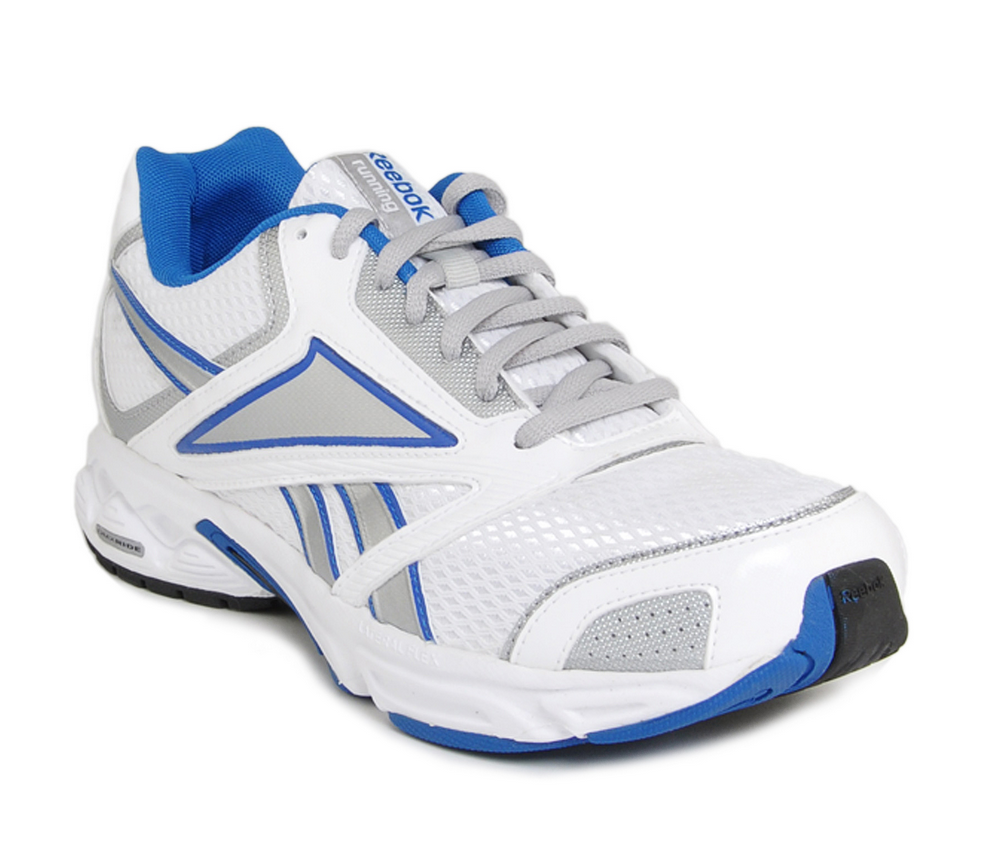


🧠 Similarity Results:

🖼️ File: 3463.jpg
📏 Distance: 0.0010087841972906686


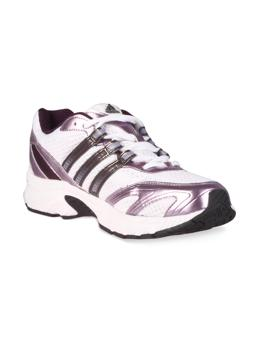


🖼️ File: 31978.jpg
📏 Distance: 0.001091635414875669


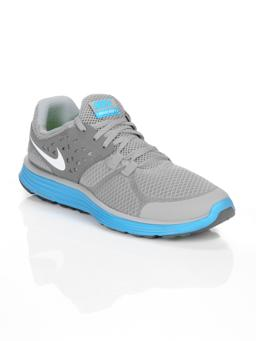


🖼️ File: 51741.jpg
📏 Distance: 0.0011929319084955647


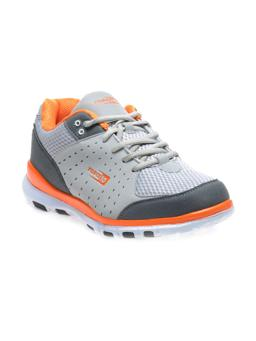

In [53]:
# Run Similarity Search
execute_similarity_search('153622.jpg', 3) # IMG_5926, IMG_5933, IMG_5935